## IE48B - HW2
### H.Pınar Yıldırım

In [1]:
getwd()
setwd('C:/Users/asus_pinar/desktop/files')
getwd()

[1] "C:/Users/asus_pinar"

[1] "C:/Users/asus_pinar/desktop/files"

In [2]:
library(genlasso)
library(data.table)
library(rpart)
library(repr)
library(ggplot2)
options(scipen=999)
options(repr.plot.width=15, repr.plot.height=8)

Warning message:
"package 'genlasso' was built under R version 3.6.3"Loading required package: Matrix
Loading required package: igraph
Warning message:
"package 'igraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'data.table' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [3]:
get_mse <- function(actual, fitted) {
    if(length(actual) != length(fitted)){
        return("Different lengths")
    }
    
    error = array()
    
    for (i in 1:length(actual)){
    error[i] = (actual[i] - fitted[i])**2
    }
    
   return(mean(error))     
}


### INTRODUCTION

CBF data consists of 30 time series where each series have 128 observations. Each time series belongs one of the classes Cylinder, Bell or Funnel. 

In [4]:
cbf_data = fread("CBF_TRAIN.txt")
#summary(cbf_data)
min(cbf_data)
max(cbf_data)
nrow(cbf_data)
ncol(cbf_data)
head(cbf_data)

[1] -2.316862

[1] 3.244565

[1] 30

[1] 129

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129
1,-0.4642765,-0.5550479,-0.84284310,-0.86589548,-0.9363963,-0.8172700,-0.2636122,-1.25804830,-1.2503934,...,-1.3310856,-1.0837000,-1.0179615,-0.9160287,-1.1342892,-0.9202237,-0.7893615,-0.6387058,-0.9636643,-1.24516910
1,-0.8969721,-0.6856855,-1.35138180,-1.45866680,-1.1653456,-1.4039293,-1.8217996,-0.83160109,-1.0163124,...,-1.0625534,-1.5686762,-1.3640403,-1.1551774,-0.9958611,-1.1637529,-0.9165233,-0.5820981,-1.2590094,-1.39252410
1,-0.4646960,-0.5677389,-0.03202276,-0.63504562,-0.6028255,-0.2668563,-0.2670613,-0.93104230,-0.4493819,...,-0.2867213,-0.6371576,-0.1552602,-0.6881293,-0.8856088,-0.7662393,-0.8653152,-0.2844857,-0.6878891,-0.88760835
3,-0.1871897,-0.6208077,-0.81566070,-0.52139796,-0.7904229,-0.9675174,-1.4870063,-0.27788714,-0.8350747,...,-0.9086154,-0.7262865,0.1837776,-0.7374441,-1.1139967,-0.3939866,-0.5878895,-0.6082319,-0.6364646,-0.34902865
2,-1.1360166,-1.3191953,-1.84462380,-0.78869178,-0.2517154,-1.4876032,-0.6687641,-0.34036037,-1.0463815,...,-1.1829110,-1.0735136,-1.6113624,-1.0643404,-0.9707364,-0.8272809,-0.9535377,-1.2701854,-1.7427579,-0.92594391
2,-0.5687087,-0.8881180,-0.04797658,-0.03803611,-0.4830683,-1.0946887,-0.9534529,-0.03000688,-0.7954546,...,-0.9907398,0.5183746,-0.2285628,-0.5652887,-0.6429980,-1.1094278,-0.1010932,-0.2339490,-0.6198269,-0.08306189


V1 is the class variable. V2 to V129 are observations. There are 30 time series instances which have similar scales. The largest observation is 3.24 and the smallest observation is -2.32.

###  FUSED LASSO APPROACH

Inputs to fusedlasso1d are obtained by removing the first column, class variable.

In [5]:
cbf_data[1,-1]

V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129
-0.4642765,-0.5550479,-0.8428431,-0.8658955,-0.9363963,-0.81727,-0.2636122,-1.258048,-1.250393,-0.9183083,...,-1.331086,-1.0837,-1.017961,-0.9160287,-1.134289,-0.9202237,-0.7893615,-0.6387058,-0.9636643,-1.245169


In [6]:
inputs = array(dim=c(nrow(cbf_data), ncol(cbf_data)-1))

for (i in 1:nrow(cbf_data)){
    dummy = as.matrix(cbf_data[i,-1])
    colnames(dummy) = NULL
    inputs[i,] =array(dummy)
}

dim(inputs)
head(inputs)


[1]  30 128

-0.4642765,-0.5550479,-0.84284310,-0.86589548,-0.9363963,-0.8172700,-0.2636122,-1.25804830,-1.2503934,-0.91830825,...,-1.3310856,-1.0837000,-1.0179615,-0.9160287,-1.1342892,-0.9202237,-0.7893615,-0.6387058,-0.9636643,-1.24516910
-0.8969721,-0.6856855,-1.35138180,-1.45866680,-1.1653456,-1.4039293,-1.8217996,-0.83160109,-1.0163124,-0.80353040,...,-1.0625534,-1.5686762,-1.3640403,-1.1551774,-0.9958611,-1.1637529,-0.9165233,-0.5820981,-1.2590094,-1.39252410
-0.4646960,-0.5677389,-0.03202276,-0.63504562,-0.6028255,-0.2668563,-0.2670613,-0.93104230,-0.4493819,-0.72134200,...,-0.2867213,-0.6371576,-0.1552602,-0.6881293,-0.8856088,-0.7662393,-0.8653152,-0.2844857,-0.6878891,-0.88760835
-0.1871897,-0.6208077,-0.81566070,-0.52139796,-0.7904229,-0.9675174,-1.4870063,-0.27788714,-0.8350747,0.05059104,...,-0.9086154,-0.7262865,0.1837776,-0.7374441,-1.1139967,-0.3939866,-0.5878895,-0.6082319,-0.6364646,-0.34902865
-1.1360166,-1.3191953,-1.84462380,-0.78869178,-0.2517154,-1.4876032,-0.6687641,-0.34036037,-1.0463815,-0.31221353,...,-1.1829110,-1.0735136,-1.6113624,-1.0643404,-0.9707364,-0.8272809,-0.9535377,-1.2701854,-1.7427579,-0.92594391
-0.5687087,-0.8881180,-0.04797658,-0.03803611,-0.4830683,-1.0946887,-0.9534529,-0.03000688,-0.7954546,-0.51445458,...,-0.9907398,0.5183746,-0.2285628,-0.5652887,-0.6429980,-1.1094278,-0.1010932,-0.2339490,-0.6198269,-0.08306189


fusedlasso01d function is called for each series.

In [7]:
outputs=list()

for (i in 1:nrow(inputs)){

    outputs[[i]] = fusedlasso1d(inputs[i,])

}

outputs 1 to 30

In [8]:
outputs[[1]]
head(summary(outputs[[1]]))
str(outputs[[1]])


Call:
fusedlasso1d(y = inputs[i, ])

Output:
Path model with 127 total steps.


df,lambda,rss
1,35.655822,127.00000
2,27.226605,108.43739
3,7.315693,19.53753
4,5.962232,17.08796
5,5.153002,15.85341
6,2.740450,13.04129


List of 12
 $ lambda      : num [1:127] 35.66 27.23 7.32 5.96 5.15 ...
 $ beta        : num [1:128, 1:127] 0.000000000703 0.000000000703 0.000000000703 0.000000000703 0.000000000703 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:127] "35.656" "27.227" "7.316" "5.962" ...
 $ fit         : num [1:128, 1:127] 0.000000000703 0.000000000703 0.000000000703 0.000000000703 0.000000000703 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:127] "35.656" "27.227" "7.316" "5.962" ...
 $ u           : num [1:127, 1:127] 0.464 1.019 1.862 2.728 3.664 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:127] "35.656" "27.227" "7.316" "5.962" ...
 $ hit         : logi [1:127] TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ df          : num [1:127] 1 2 3 4 5 6 7 8 9 10 ...
 $ y           : num [1:128] -0.464 -0.555 -0.843 -0.866 -0.936 ...
 $ completepath: logi TRUE
 $ bls         : num [1:128] -0.464 -0.555 -0.843 -0.866 -0.936 ...
 $ pathob

In [9]:
outputs[[30]]
head(summary(outputs[[30]]))
str(outputs[[30]])


Call:
fusedlasso1d(y = inputs[i, ])

Output:
Path model with 127 total steps.


df,lambda,rss
1,31.288284,127.00000
2,29.523381,122.09364
3,7.554883,19.50600
4,5.871854,16.60043
5,3.998243,14.20278
6,3.773940,13.96809


List of 12
 $ lambda      : num [1:127] 31.29 29.52 7.55 5.87 4 ...
 $ beta        : num [1:128, 1:127] 0.000000000781 0.000000000781 0.000000000781 0.000000000781 0.000000000781 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:127] "31.288" "29.523" "7.555" "5.872" ...
 $ fit         : num [1:128, 1:127] 0.000000000781 0.000000000781 0.000000000781 0.000000000781 0.000000000781 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:127] "31.288" "29.523" "7.555" "5.872" ...
 $ u           : num [1:127, 1:127] 0.993 1.863 2.208 3.205 4.947 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:127] "31.288" "29.523" "7.555" "5.872" ...
 $ hit         : logi [1:127] TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ df          : num [1:127] 1 2 3 4 5 6 7 8 9 10 ...
 $ y           : num [1:128] -0.993 -0.869 -0.345 -0.997 -1.743 ...
 $ completepath: logi TRUE
 $ bls         : num [1:128] -0.993 -0.869 -0.345 -0.997 -1.743 ...
 $ pathobjs 

Can find lambda with smallest cross validation error (lambda.min) using cv.trendfilter function. The function also returns the lambda which results in cv error 1-standart error away from the smallest error (lambda.1se).

In [10]:
#cross validation calls with k=10

cross_val = list()

for (i in 1:nrow(inputs)){

    cross_val[[i]] = cv.trendfilter(outputs[[i]], k=10)
    
}
 

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 

Minimum Cross-Validation Error Lambdas for each series:

In [11]:
lambdas=list()
for (i in 1:nrow(inputs)){

    lambdas[i] = cross_val[[i]]$lambda.min
    
}
 

In [12]:
lambdas

[[1]]
[1] 0.7435113

[[2]]
[1] 0.6212955

[[3]]
[1] 0.6623808

[[4]]
[1] 1.308851

[[5]]
[1] 1.02162

[[6]]
[1] 1.010619

[[7]]
[1] 1.418188

[[8]]
[1] 1.193038

[[9]]
[1] 1.012008

[[10]]
[1] 0.1519257

[[11]]
[1] 0.9873853

[[12]]
[1] 0.8361207

[[13]]
[1] 0.8693928

[[14]]
[1] 0.8146329

[[15]]
[1] 1.046266

[[16]]
[1] 0.9764708

[[17]]
[1] 0.5506219

[[18]]
[1] 1.111181

[[19]]
[1] 0.9706832

[[20]]
[1] 0.3620265

[[21]]
[1] 0.9586536

[[22]]
[1] 0.5882071

[[23]]
[1] 0.7744089

[[24]]
[1] 1.200834

[[25]]
[1] 1.108847

[[26]]
[1] 0.825461

[[27]]
[1] 1.081777

[[28]]
[1] 1.371785

[[29]]
[1] 1.265857

[[30]]
[1] 0.5448199

### REGRESSION TREE APPROACH

Data is prepared to include time indexes as well as observations. 

In [13]:
cbf_df = as.data.frame(t(cbf_data[,-1]))
colnames(cbf_df) = paste("obs",  1:30, sep="")
cbf_df = cbind(time=as.integer(1:128), cbf_df)
head(cbf_df)

,time,obs1,obs2,obs3,obs4,obs5,obs6,obs7,obs8,obs9,...,obs21,obs22,obs23,obs24,obs25,obs26,obs27,obs28,obs29,obs30
V2,1,-0.4642765,-0.8969721,-0.46469596,-0.1871897,-1.1360166,-0.56870868,-0.9658386,-0.2643018,-0.80371556,...,-1.4516799,-0.5344525,-1.086040,-1.676169,-1.3148891,-0.1909214,-0.19181256,-0.18049272,-0.26588817,-0.9933152
V3,2,-0.5550479,-0.6856855,-0.56773891,-0.6208077,-1.3191953,-0.88811805,-1.6445832,-0.2909255,-0.04816053,...,-1.4452721,-0.9543537,-1.199305,-1.839363,-1.3508606,-0.6160513,-0.04609017,-0.98893115,0.01312794,-0.8694194
V4,3,-0.8428431,-1.3513818,-0.03202276,-0.8156607,-1.8446238,-0.04797658,-1.8059354,-0.5985672,-1.29927820,...,-1.0735985,-0.8067110,-1.120579,-1.833647,-0.5748194,-0.5980286,-1.36523740,-0.30170209,-1.02886140,-0.3451353
V5,4,-0.8658955,-1.4586668,-0.63504562,-0.5213980,-0.7886918,-0.03803611,-1.4996576,-0.5188631,-1.07227980,...,-1.2672501,-1.2468315,-1.196342,-1.914525,-0.7137832,-0.6254470,-0.90739761,-0.47536458,-1.09010810,-0.9969026
V6,5,-0.9363963,-1.1653456,-0.60282554,-0.7904229,-0.2517154,-0.48306827,-0.9200879,-0.4885939,-1.00401800,...,-0.7006503,-0.9643141,-1.952206,-1.755839,-1.7298737,-0.1525075,-0.86673694,-1.13526940,-1.88205850,-1.7425352
V7,6,-0.8172700,-1.4039293,-0.26685628,-0.9675174,-1.4876032,-1.09468870,-1.1157058,-0.4070914,-0.51145233,...,-1.8999688,-1.2763088,-1.272486,-1.018323,-1.1608359,-0.7663299,-1.19013170,-0.05728922,-0.56559420,-1.5874918


In [14]:
cbf_df$obs1 == inputs[1,]  

#checking for consistency

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

Trees are trained with parameters cp=0, minsplit=20, minbucket=10. To define maxdepth parameter a cross-validation approach is applied. In this approach training set and test set is prepared such that one of each ten observations is in the test set and remaining are in the train set. After training a tree with the train set and recording the MSE on the test set, another fold is prepared with the same approach but with different observations in the test set. 

This is repeated 10 times for each series and for each depth value (2,4,6,7). For each series the depth with minimum cross-validation average MSE is selected as the maxdepth parameter for further tasks. 

In [15]:

cv_tree=data.frame(series = numeric(0), depth = numeric(0), AVGMSE = numeric(0))
depth=c(2,4,6,7)


#for each series

for(series in 2:31){
tree_df = rbind(cbf_df[,1], cbf_df[,series])
tree_df = as.data.frame(tree_df)
tree_df=transpose(tree_df)
colnames(tree_df)=c("time", "obs")
head(tree_df)

            for(m in 1: length(depth)){  #for each depth
                   
                   MSE_test = array()

                    for(test_index in 1:10){   #for each fold

                    test_set = data.frame()
                    train_set = data.frame()

                            for (j in 1:length(tree_df$time)){               #seperate test set and train set
                                if(j == test_index){
                                    test_set = rbind(test_set,tree_df[j,])
                                    test_index = test_index+10
                                }
                                else{
                                train_set=rbind(train_set, tree_df[j,])
                                } 
                            }                                               #####################


                    control_tree=rpart.control(cp=0, minsplit=20, minbucket=10, maxdepth=depth[m])   ## train tree
                    tr = rpart(obs~time, data=train_set, control=control_tree)

                    
                    est = predict(tr, newdata=tree_df)
                    


                    MSE_test = append(MSE_test, get_mse(test_set$obs,est[test_set$time]))           #get MSE on the test set 
                    
                    }
                    
                    MSE_test = MSE_test[-1]  #removing the first entry which is NULL due to append
                    cv_tree = rbind(cv_tree,transpose(as.data.frame(c(series-1,depth[m],mean(MSE_test)))))   #record AVG MSE over all folds
            }
}


Average MSE errors for each depth (2,4,6,7) and for each series 1 to 30.

In [16]:
cv_tree

V1,V2,V3
1,2,0.1723903
1,4,0.1721060
1,6,0.1719053
1,7,0.1719053
2,2,0.1921785
2,4,0.2057848
2,6,0.2099895
2,7,0.2099895
3,2,0.1779003
3,4,0.1850596


For each series 1 to 30 depth with minimum average error selected. If there are equal values the smallest depth value is chosen since simpler models are preferred.

In [33]:
cv_tree = as.data.table(cv_tree)
min_cv_depths = data.table()

for(i in 1:30){
min_cv_depths=rbind(min_cv_depths, cv_tree[V1 == i & V3==cv_tree[V1==i,min(V3),] & V2 ==cv_tree[V1==i & V3==cv_tree[V1==i,min(V3),],min(V2)] ,])
}

min_cv_depths

V1,V2,V3
1,6,0.1719053
2,2,0.1921785
3,2,0.1779003
4,4,0.2705618
5,6,0.2922782
6,6,0.4193961
7,2,0.1611027
8,6,0.3100171
9,6,0.2576233
10,2,0.1655365


### TREE VS FUSED LASSO

Two approaches will be compared based on the MSE distributions.
Tree parameters will be cp=0, minsplit=20, minbucket=10 and maxdepth as calculated for each series.
Fused lasso lambda values are also calculated.

Tree maxdepth values which resulted in min cv errors are:

In [18]:
colnames(min_cv_depths)=c("series", "depth", "AVGMSE")
min_cv_depths

series,depth,AVGMSE
1,6,0.1719053
2,2,0.1921785
3,2,0.1779003
4,4,0.2705618
5,6,0.2922782
6,6,0.4193961
7,2,0.1611027
8,6,0.3100171
9,6,0.2576233
10,2,0.1655365


Lambda values which result in min cv error for fused lasso are:

In [19]:
lambdas

[[1]]
[1] 0.7435113

[[2]]
[1] 0.6212955

[[3]]
[1] 0.6623808

[[4]]
[1] 1.308851

[[5]]
[1] 1.02162

[[6]]
[1] 1.010619

[[7]]
[1] 1.418188

[[8]]
[1] 1.193038

[[9]]
[1] 1.012008

[[10]]
[1] 0.1519257

[[11]]
[1] 0.9873853

[[12]]
[1] 0.8361207

[[13]]
[1] 0.8693928

[[14]]
[1] 0.8146329

[[15]]
[1] 1.046266

[[16]]
[1] 0.9764708

[[17]]
[1] 0.5506219

[[18]]
[1] 1.111181

[[19]]
[1] 0.9706832

[[20]]
[1] 0.3620265

[[21]]
[1] 0.9586536

[[22]]
[1] 0.5882071

[[23]]
[1] 0.7744089

[[24]]
[1] 1.200834

[[25]]
[1] 1.108847

[[26]]
[1] 0.825461

[[27]]
[1] 1.081777

[[28]]
[1] 1.371785

[[29]]
[1] 1.265857

[[30]]
[1] 0.5448199

#### FUSED LASSO AND TREE ESTIMATIONS AND MSE VALUES FOR EACH SERIES 

In [20]:
MSE_values = data.frame(series = numeric(0), FL_MSE = numeric(0), TREE_MSE = numeric(0))
MSE_values


tr=list()

for(i in 1:30){


### FUSED LASSO

#print(ggplot()+geom_line(aes(y=cbf_df[,i+1], x=cbf_df[,1], col="actual"))
#+geom_line(aes(x=cbf_df[,1],y=coef(outputs[[i]], lambda=cross_val[[i]]$lambda.min)$beta, col="predicted"))
#+labs(title=paste("Series", i, "FusedLasso"), x="time", y="value")
#)



MSE_FL = get_mse(cbf_df[,i+1], coef(outputs[[i]], lambda=cross_val[[i]]$lambda.min)$beta)
print(paste("FusedLasso MSE", i))
print(MSE_FL)



### TREE

#control parameters with min cv error depth
control_tree=rpart.control(cp=0, minsplit=20, minbucket=10, maxdepth=min_cv_depths[i,]$depth)  


train_set = cbind(cbf_df[,1], cbf_df[,i+1])
train_set = as.data.frame(train_set)
colnames(train_set) = c("time","obs")

tr[[i]] = rpart(obs~time, data=train_set, control=control_tree)
est= predict(tr[[i]])


#print(ggplot()+geom_line(aes(y=cbf_df[,i+1], x=cbf_df[,1], col="actual"))
#+geom_line(aes(x=cbf_df[,1],y=est, col="predicted"))
#+labs(title=paste("Series", i, "Tree"), x="time", y="value"))


MSE_TR = get_mse(cbf_df[,i+1], est)
print(paste("Tree MSE", i))
print(MSE_TR)

MSE_values = rbind(MSE_values,transpose(as.data.frame(c(i, MSE_FL, MSE_TR ))))

}


series,FL_MSE,TREE_MSE


[1] "FusedLasso MSE 1"
[1] 0.07582339
[1] "Tree MSE 1"
[1] 0.07603541
[1] "FusedLasso MSE 2"
[1] 0.08875735
[1] "Tree MSE 2"
[1] 0.104584
[1] "FusedLasso MSE 3"
[1] 0.07374431
[1] "Tree MSE 3"
[1] 0.09406769
[1] "FusedLasso MSE 4"
[1] 0.1578456
[1] "Tree MSE 4"
[1] 0.1678914
[1] "FusedLasso MSE 5"
[1] 0.1530735
[1] "Tree MSE 5"
[1] 0.1562883
[1] "FusedLasso MSE 6"
[1] 0.1909758
[1] "Tree MSE 6"
[1] 0.2068958
[1] "FusedLasso MSE 7"
[1] 0.1071874
[1] "Tree MSE 7"
[1] 0.108132
[1] "FusedLasso MSE 8"
[1] 0.1861418
[1] "Tree MSE 8"
[1] 0.1853677
[1] "FusedLasso MSE 9"
[1] 0.1411696
[1] "Tree MSE 9"
[1] 0.1417046
[1] "FusedLasso MSE 10"
[1] 0.02709995
[1] "Tree MSE 10"
[1] 0.1034123
[1] "FusedLasso MSE 11"
[1] 0.1567946
[1] "Tree MSE 11"
[1] 0.1621091
[1] "FusedLasso MSE 12"
[1] 0.1959947
[1] "Tree MSE 12"
[1] 0.2155064
[1] "FusedLasso MSE 13"
[1] 0.1297015
[1] "Tree MSE 13"
[1] 0.2340838
[1] "FusedLasso MSE 14"
[1] 0.1386076
[1] "Tree MSE 14"
[1] 0.1583207
[1] "FusedLasso MSE 15"
[1] 0.1745

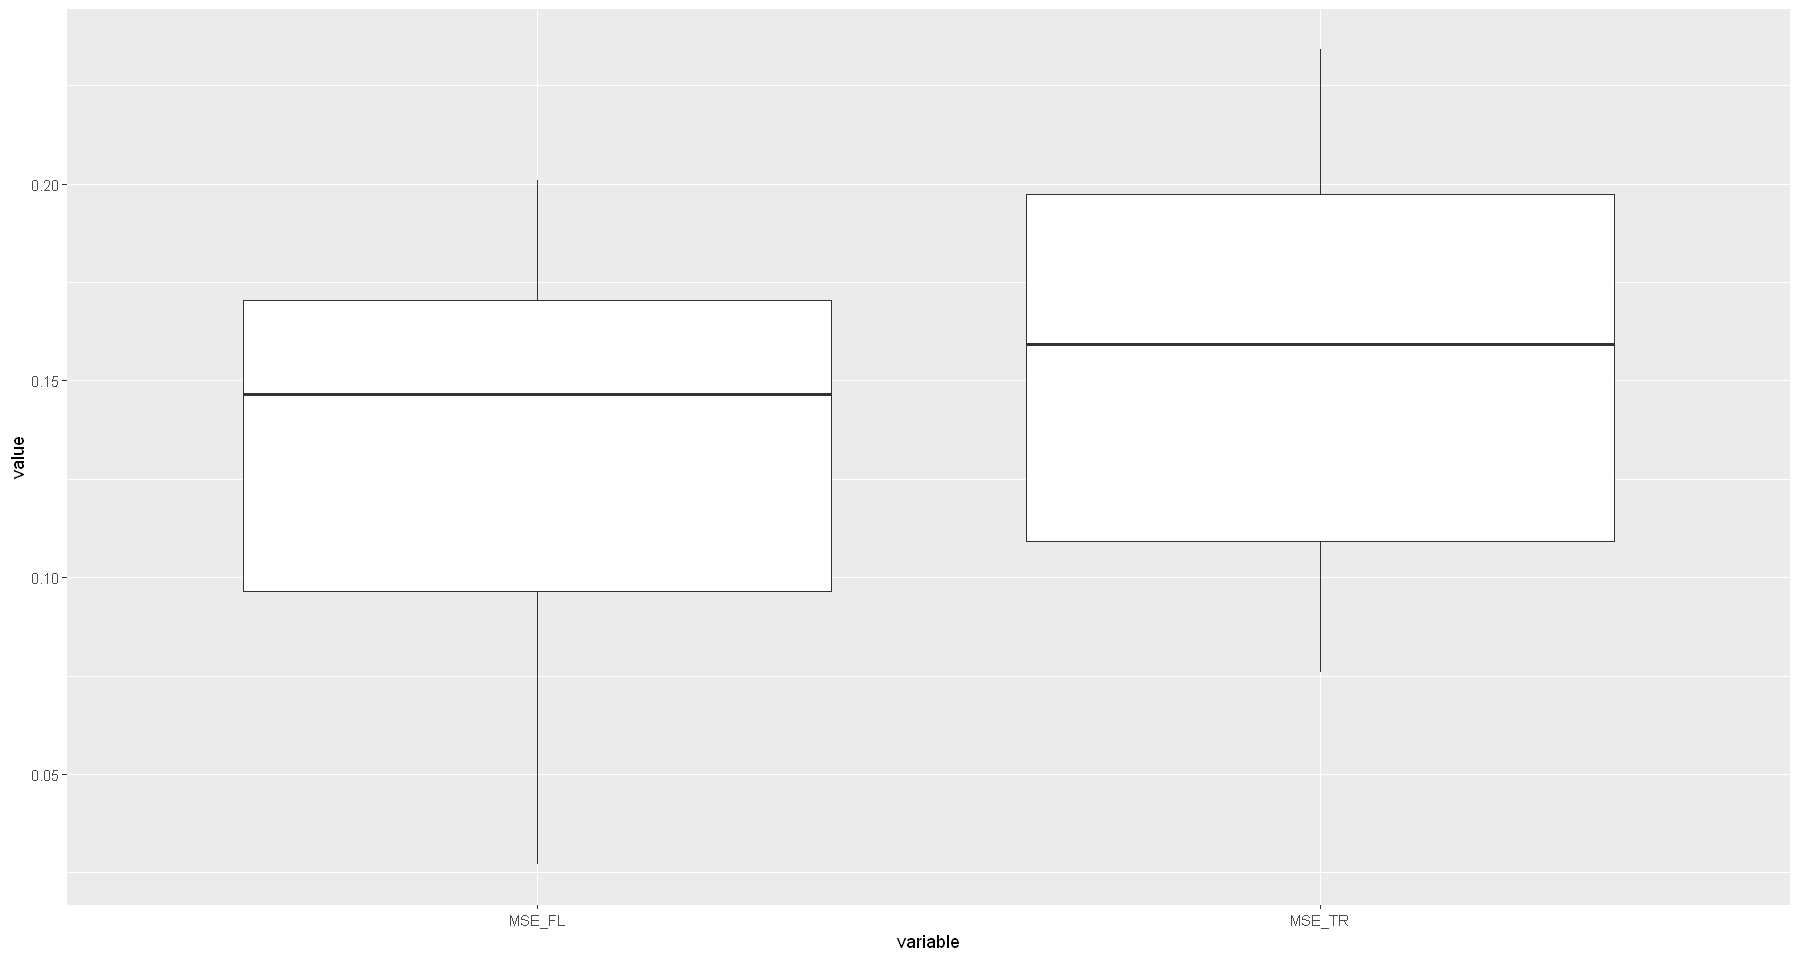

In [21]:
colnames(MSE_values)=c("series", "MSE_FL", "MSE_TR")
MSE_values = as.data.table(MSE_values)
MSE_values=melt(MSE_values, id.vars="series", measure.vars=c("MSE_FL", "MSE_TR") )

ggplot()+geom_boxplot(data=MSE_values, aes(y=value, x=variable))


Methods have close mean MSE values. Distribution of tree errors are balanced towards high and low values while distribution of FusedLasso errors are denser in lower values.

###  1-NN CLASSIFIERS COMPARISON

Two approaches will be compared based on their accuracy as a 1-NN classifier

For raw data, fusedlasso estimations and regression tree estimations distances between series are calculated with dist function and stored as a dist object. 

Then for each series Nearest Neighbor is determined and the series classified accordingly.

In the end, accuracy measures of three approaches are compared

In [22]:
inputs
dim(inputs)

-0.46427649,-0.55504787,-0.84284310,-0.86589548,-0.9363963,-0.81726995,-0.26361216,-1.25804830,-1.25039340,-0.91830825,...,-1.3310856,-1.0837000,-1.0179615,-0.91602872,-1.1342892,-0.92022369,-0.78936150000,-0.63870583,-0.9636643,-1.24516910
-0.89697208,-0.68568553,-1.35138180,-1.45866680,-1.1653456,-1.40392930,-1.82179960,-0.83160109,-1.01631240,-0.80353040,...,-1.0625534,-1.5686762,-1.3640403,-1.15517740,-0.9958611,-1.16375290,-0.91652327000,-0.58209806,-1.2590094,-1.39252410
-0.46469596,-0.56773891,-0.03202276,-0.63504562,-0.6028255,-0.26685628,-0.26706128,-0.93104230,-0.44938186,-0.72134200,...,-0.2867213,-0.6371576,-0.1552602,-0.68812931,-0.8856088,-0.76623926,-0.86531525000,-0.28448570,-0.6878891,-0.88760835
-0.18718975,-0.62080772,-0.81566070,-0.52139796,-0.7904229,-0.96751744,-1.48700630,-0.27788714,-0.83507474,0.05059104,...,-0.9086154,-0.7262865,0.1837776,-0.73744409,-1.1139967,-0.39398661,-0.58788950000,-0.60823187,-0.6364646,-0.34902865
-1.13601660,-1.31919530,-1.84462380,-0.78869178,-0.2517154,-1.48760320,-0.66876407,-0.34036037,-1.04638150,-0.31221353,...,-1.1829110,-1.0735136,-1.6113624,-1.06434040,-0.9707364,-0.82728087,-0.95353773000,-1.27018540,-1.7427579,-0.92594391
-0.56870868,-0.88811805,-0.04797658,-0.03803611,-0.4830683,-1.09468870,-0.95345287,-0.03000688,-0.79545456,-0.51445458,...,-0.9907398,0.5183746,-0.2285628,-0.56528868,-0.6429980,-1.10942780,-0.10109322000,-0.23394901,-0.6198269,-0.08306189
-0.96583857,-1.64458320,-1.80593540,-1.49965760,-0.9200879,-1.11570580,-0.65019532,-0.91876634,-1.23470800,-0.76566200,...,-1.0725346,-1.0630339,-1.3165634,-0.73573890,-1.0521517,-0.96046486,-1.13356590000,-0.61034365,-1.1652195,-0.68589892
-0.26430177,-0.29092547,-0.59856716,-0.51886312,-0.4885939,-0.40709142,-1.07148850,-1.09570570,-0.58450283,-1.05790880,...,-1.1660852,-0.1918801,-0.1229107,-0.70074636,-0.5878704,-0.76991747,0.19209267000,-1.44315440,-1.0394812,-0.63120869
-0.80371556,-0.04816053,-1.29927820,-1.07227980,-1.0040180,-0.51145233,-1.17321550,-0.42206193,-0.77931962,-1.03058550,...,-1.8488276,-0.5494321,-0.9682693,-0.35398297,-0.5958916,-0.60619449,-0.86444414000,-0.70619191,-1.3886558,-0.65071018
-1.18642220,-0.89319697,-0.97773692,-0.63410927,-1.3848198,-1.27192610,-1.21217110,-1.45279170,-0.93441701,-1.11842470,...,-0.8568934,-1.2176250,-0.8236537,-1.28045160,-1.5893960,-0.99829383,-0.81079982000,-0.98159057,-1.2784443,-1.10782890
-0.65330839,-1.29518480,-0.45738382,-1.09203640,-1.6823461,-0.46181073,-0.09936242,-0.83480913,-0.63588089,-1.00058260,...,-0.3910580,-0.3581094,-1.1634350,-0.40071116,-0.4097597,-0.72094741,-0.33299027000,0.54820399,-0.5962288,-0.19067185


[1]  30 128

In [23]:
euc_dist_raw = dist((inputs), method="euclidean", upper = T)
euc_dist_raw

           1         2         3         4         5         6         7
1             9.449364  9.358967 13.245768 15.840525 11.513919  8.675663
2   9.449364           11.016553 11.644152 16.722127 12.470209  7.508033
3   9.358967 11.016553           10.732494 17.413129  9.420593 10.199629
4  13.245768 11.644152 10.732494           17.788814 14.211284 11.335166
5  15.840525 16.722127 17.413129 17.788814           16.714189 16.447398
6  11.513919 12.470209  9.420593 14.211284 16.714189           11.778372
7   8.675663  7.508033 10.199629 11.335166 16.447398 11.778372          
8  14.200934 11.445306 12.074778 10.327663 18.746085 14.414487 12.535251
9  11.216289 10.989391 14.891405 16.507923 13.402473 13.972013 11.109987
10  8.071055  7.836692  9.532770 11.356598 16.527378 11.761546  6.114213
11  8.820555 11.049433 11.429615 15.088093 15.981794 11.133898 10.783411
12  9.960345 12.366754 12.245147 15.999206 15.130952 11.556315 11.288172
13 11.333048 13.157485 13.230752 14.493998 11.89059

In [24]:
m = as.matrix(euc_dist_raw)
diag(m) = NA
min_dist = apply(m,2,min,na.rm=TRUE)
min_index = apply(m,2, which.min)

In [25]:
NN_classifier = data.table(series = c(1:30))
NN_classifier$class = cbf_data$V1
NN_classifier$NN_raw = min_index
NN_classifier$NN_raw_class=cbf_data$V1[min_index]
NN_classifier$NN_raw_correct =(NN_classifier$class==NN_classifier$NN_raw_class)
NN_classifier

series,class,NN_raw,NN_raw_class,NN_raw_correct
1,1,25,3,FALSE
2,1,7,1,TRUE
3,1,28,3,FALSE
4,3,20,3,TRUE
5,2,15,2,TRUE
6,2,27,2,TRUE
7,1,10,1,TRUE
8,3,20,3,TRUE
9,2,14,2,TRUE
10,1,7,1,TRUE


FusedLasso Representations

In [26]:
FL_rep = data.frame(time = c(1:128))
for(i in 1:30){
FL_rep = cbind(FL_rep, coef(outputs[[i]], lambda=cross_val[[i]]$lambda.min)$beta[,1])
}

euc_dist_FL = dist(transpose(FL_rep[,-1]), method="euclidean", upper=TRUE)
euc_dist_FL


           1         2         3         4         5         6         7
1             7.652124  7.904467 11.046131 14.145414  8.825189  6.072295
2   7.652124            9.450797  9.945549 14.881082 10.029359  4.636434
3   7.904467  9.450797            7.996591 15.955610  6.349780  8.579064
4  11.046131  9.945549  7.996591           15.752458 11.167133  9.269594
5  14.145414 14.881082 15.955610 15.752458           14.414955 14.418326
6   8.825189 10.029359  6.349780 11.167133 14.414955            9.347339
7   6.072295  4.636434  8.579064  9.269594 14.418326  9.347339          
8  12.348304  9.267879  9.901796  6.689503 16.615062 11.569091 10.055383
9   8.905342  8.668917 13.333334 14.585869 11.250260 11.961211  8.659857
10  5.947014  5.998824  8.505677  9.658694 15.151991  9.477190  3.877645
11  6.120088  8.808765  9.400784 12.488360 13.785654  7.984414  7.757789
12  7.299113  9.504340 10.137615 13.019649 13.021715  8.400904  8.575805
13  9.813524 11.706301 11.535326 12.333096  9.24719

In [27]:

m = as.matrix(euc_dist_FL)
diag(m) = NA
min_dist_FL = apply(m,2,min,na.rm=TRUE)
min_index_FL = apply(m,2, which.min)
NN_classifier$NN_FL = min_index_FL
NN_classifier$NN_FL_class = cbf_data$V1[min_index_FL]
NN_classifier$NN_FL_correct =(NN_classifier$class==NN_classifier$NN_FL_class)



In [28]:
NN_classifier

series,class,NN_raw,NN_raw_class,NN_raw_correct,NN_FL,NN_FL_class,NN_FL_correct
1,1,25,3,FALSE,25,3,FALSE
2,1,7,1,TRUE,7,1,TRUE
3,1,28,3,FALSE,28,3,FALSE
4,3,20,3,TRUE,28,3,TRUE
5,2,15,2,TRUE,15,2,TRUE
6,2,27,2,TRUE,27,2,TRUE
7,1,10,1,TRUE,10,1,TRUE
8,3,20,3,TRUE,20,3,TRUE
9,2,14,2,TRUE,14,2,TRUE
10,1,7,1,TRUE,7,1,TRUE


TREE REPRESENTATION

In [29]:
TR_rep = data.frame(time = c(1:128))
for(i in 1:30){
TR_rep = cbind(TR_rep, predict(tr[[i]]))
}

euc_dist_TR = dist(transpose(TR_rep[,-1]), method="euclidean", upper=TRUE)
euc_dist_TR

           1         2         3         4         5         6         7
1             7.998946  8.558043 11.736703 14.719428  9.313004  6.782542
2   7.998946           10.103099 10.666992 15.526494 10.636952  5.147560
3   8.558043 10.103099            8.367926 16.505143  6.654277  9.299874
4  11.736703 10.666992  8.367926           16.559313 11.839333 10.131451
5  14.719428 15.526494 16.505143 16.559313           15.175803 15.423617
6   9.313004 10.636952  6.654277 11.839333 15.175803            9.879745
7   6.782542  5.147560  9.299874 10.131451 15.423617  9.879745          
8  12.779044 10.101568 10.120826  7.459503 17.377901 12.333108 10.719052
9   9.682164  8.790290 14.047425 15.158746 11.737775 12.623641  9.334507
10  6.032134  5.677672  8.917384  9.966364 15.446955  9.772909  3.441732
11  6.925731  9.363111 10.006237 13.397108 14.693242  8.785715  8.793160
12  7.682866  9.645177 10.519914 13.743194 13.976169  9.294536  9.120511
13  9.722298 11.427799 11.231284 12.345883  9.35762

In [30]:

m = as.matrix(euc_dist_TR)
diag(m) = NA
min_dist_TR = apply(m,2,min,na.rm=TRUE)
min_index_TR = apply(m,2, which.min)
NN_classifier$NN_TR = min_index_TR
NN_classifier$NN_TR_class = cbf_data$V1[min_index_TR]
NN_classifier$NN_TR_correct =(NN_classifier$class==NN_classifier$NN_TR_class)



In [31]:
NN_classifier

series,class,NN_raw,NN_raw_class,NN_raw_correct,NN_FL,NN_FL_class,NN_FL_correct,NN_TR,NN_TR_class,NN_TR_correct
1,1,25,3,FALSE,25,3,FALSE,25,3,FALSE
2,1,7,1,TRUE,7,1,TRUE,7,1,TRUE
3,1,28,3,FALSE,28,3,FALSE,28,3,FALSE
4,3,20,3,TRUE,28,3,TRUE,20,3,TRUE
5,2,15,2,TRUE,15,2,TRUE,15,2,TRUE
6,2,27,2,TRUE,27,2,TRUE,27,2,TRUE
7,1,10,1,TRUE,10,1,TRUE,10,1,TRUE
8,3,20,3,TRUE,20,3,TRUE,20,3,TRUE
9,2,14,2,TRUE,14,2,TRUE,14,2,TRUE
10,1,7,1,TRUE,7,1,TRUE,7,1,TRUE


In [32]:
print("Raw Inputs Correct Class Ratio")
print(sum(NN_classifier$NN_raw_correct)/30)

print("FusedLasso Inputs Correct Class Ratio")
print(sum(NN_classifier$NN_FL_correct)/30)

print("Tree Inputs Correct Class Ratio")
print(sum(NN_classifier$NN_TR_correct)/30)

[1] "Raw Inputs Correct Class Ratio"
[1] 0.8333333
[1] "FusedLasso Inputs Correct Class Ratio"
[1] 0.9333333
[1] "Tree Inputs Correct Class Ratio"
[1] 0.9


The best accuracy belongs to FusedLasso method. The worst results belong to the raw inputs. Unsuccessful classifications in the raw method could be due to noise in the series.

### Conclusion

FusedLasso  which is a penalized linear regression approach and regression trees are compared based on MSE and 1-NN classifier accuracies. 

FusedLasso approach performed better than regression trees for both metrics.
